In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
np.random.seed(42)
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\Piboditheowl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep = ';')
y = df.pop('quality')
for i in df.columns:
    df[i] = df[i].fillna(np.mean(df[i]))

In [3]:
scaler = StandardScaler()
df_values = scaler.fit_transform(df)

### PCA

In [4]:
pca = PCA(n_components=5)
decompose_df = pca.fit_transform(df_values)

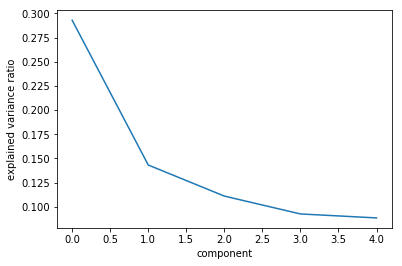

In [5]:
plt.plot(range(5),pca.explained_variance_ratio_)
plt.ylabel('explained variance ratio')
plt.xlabel('component')

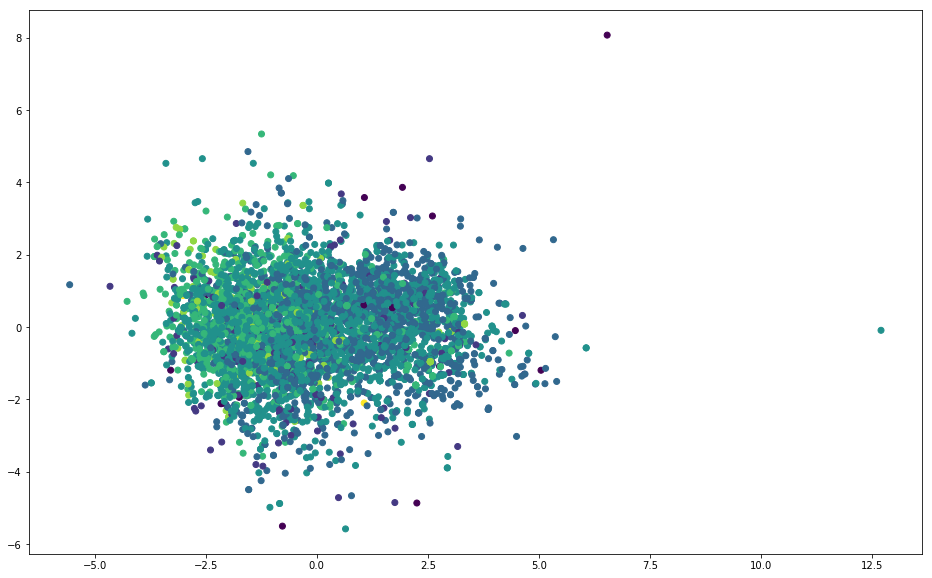

In [6]:
plt.figure(figsize=(16, 10))
plt.scatter(decompose_df[:,0], decompose_df[:,1], c = y)

In [7]:
train, test, y_train, y_test = train_test_split(decompose_df[:,[0,1]], y, test_size = 0.2)
                                                
lr = LogisticRegression()
lr.fit(train, y_train)
y_pred = lr.predict(test)
print('Accuracy score baseline PCA:', accuracy_score(y_test, y_pred))

Accuracy score baseline PCA: 0.4316326530612245


### TSNE

In [8]:
tsne = TSNE(n_components=2)
decompose_df = tsne.fit_transform(df_values)

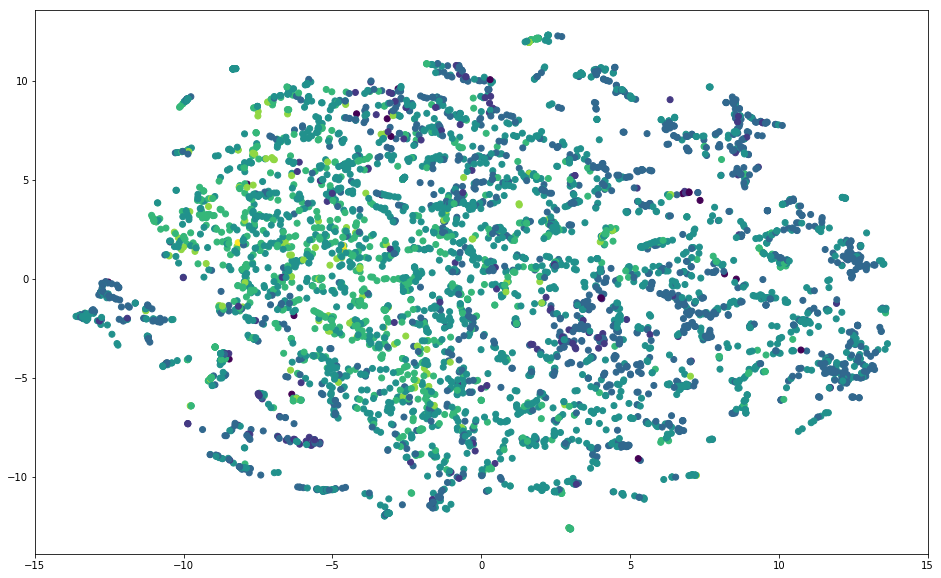

In [9]:
plt.figure(figsize=(16, 10))
plt.scatter(decompose_df[:,0], decompose_df[:,1], c = y)

In [10]:
train, test, y_train, y_test = train_test_split(decompose_df, y, test_size = 0.2)
                                                
lr = LogisticRegression()
lr.fit(train, y_train)
y_pred = lr.predict(test)
print('Accuracy score baseline TSNE:', accuracy_score(y_test, y_pred))

Accuracy score baseline TSNE: 0.46938775510204084


### Autoencoder

In [11]:
def create_autoencoder_model(object_size=df.shape[1], encoder_layer_shapes=[10, 6, 2], decoder_layer_shapes=[6, 10]):
    input_ = Input(shape=(object_size,))
    encoded = Dense(encoder_layer_shapes[0], activation='relu')(input_)
    encoded = Dense(encoder_layer_shapes[1], activation='relu')(encoded)
    encoded = Dense(encoder_layer_shapes[2])(encoded)
    decoded = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    decoded = Dense(decoder_layer_shapes[1], activation='relu')(decoded)
    decoded = Dense(object_size, activation='sigmoid')(decoded)
    
    model = Model(input_, decoded)
    model.compile(optimizer = 'Adam', loss='mean_squared_error')
    return model

In [12]:
train, test, y_train, y_test = train_test_split(df_values, y, test_size = 0.2)

In [13]:
autoencoder = create_autoencoder_model()
early_stop = EarlyStopping(monitor='val_loss',
                           patience=35,
                           verbose=0,
                           min_delta=1e-4)
reduce_lr =  ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=5,
                               cooldown=2,
                               verbose=0)

autoencoder.fit(train, train,
                epochs=2000,
                batch_size=32,
                validation_data=(test, test), callbacks = [early_stop, reduce_lr],verbose = 0)

In [14]:
model_bn = Model(autoencoder.input, autoencoder.layers[3].output)
decompose_df = model_bn.predict(df_values)

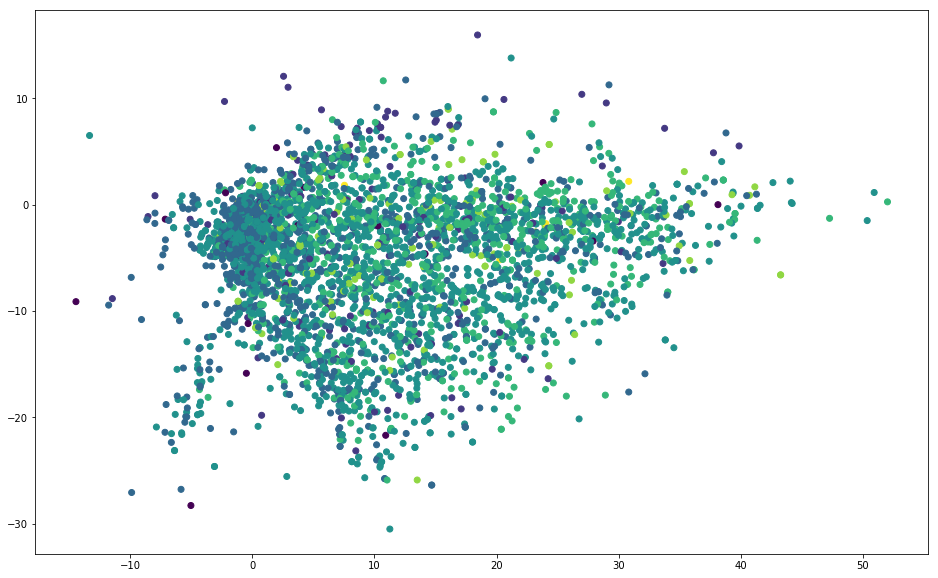

In [15]:
plt.figure(figsize=(16, 10))
plt.scatter(decompose_df[:,0], decompose_df[:,1], c = y)

In [16]:
train, test, y_train, y_test = train_test_split(decompose_df, y, test_size = 0.2)
                                                
lr = LogisticRegression()
lr.fit(train, y_train)
y_pred = lr.predict(test)
print('Accuracy score baseline AE:', accuracy_score(y_test, y_pred))

Accuracy score baseline AE: 0.4602040816326531
